# Snorkel Linto 🎧📔

### Sommaire 
#### 1. Chargement des données 
#### 2. Définition des labels 
#### 3. Séparation train/test/dev
#### 4. Ecriture des règles
#### 5. Application des règles
#### 6. Modèle génératif
#### 7. Analyse résultats
#### 8. Création fichiers utiles sur la sortie du modèle génératif 


## 1. Chargement des données

In [1]:
%matplotlib inline
import os
import numpy as np

# Turn off TensorFlow logging messages
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# For reproducibility
os.environ["PYTHONHASHSEED"] = "0"


In [2]:
import pandas as pd


DISPLAY_ALL_TEXT = True

pd.set_option("display.max_colwidth", 0 if DISPLAY_ALL_TEXT else 50)



In [3]:

import spacy

nlp = spacy.load('fr_core_news_sm')


# si pas déjà chargé: recup du modèle français
#! python -m spacy download fr_core_news_sm



In [4]:
# Dataframe à charger 

df_linto = pd.read_csv("../data/df_all_10022021.csv")

In [5]:
# Ajustements pour "coller" avec la tokénisation de spacy

df_linto.loc[df_linto.word=="aujourd'", "word"]="aujourd"
df_linto.loc[df_linto.word=="#0", "word"]="0"
df_linto.loc[df_linto.word=="95%", "word"]="95"

In [6]:
df_linto.head()

,Unnamed: 0,word,beg_word,end_word,n_round,beg_round,end_round,rank_round,text_round,sil_bef,...,prob_point_bef,prob_comma_bef,real_rank_round,pitch,energy,pitch_bef,energy_bef,punct,punct_bef,file
0,0,ok,2.00,2.37,0,0.0,10.123,0,ok donc juste comme on enregistre euh donc là c' est le le deuxième scénario,1.26,...,0.000000,0.000000,0,0,0,0,0,0,0,Linagora_P1
1,1,donc,2.73,3.01,0,0.0,10.123,1,ok donc juste comme on enregistre euh donc là c' est le le deuxième scénario,0.00,...,0.000000,0.000000,1,0,0,0,0,0,0,Linagora_P1
2,2,juste,3.38,3.67,0,0.0,10.123,2,ok donc juste comme on enregistre euh donc là c' est le le deuxième scénario,0.24,...,0.000000,0.000000,2,U,D,0,0,0,0,Linagora_P1
3,3,comme,3.92,4.22,0,0.0,10.123,3,ok donc juste comme on enregistre euh donc là c' est le le deuxième scénario,0.00,...,0.018153,0.286862,3,D,D,U,D,0,0,Linagora_P1
4,4,on,4.23,4.67,0,0.0,10.123,4,ok donc juste comme on enregistre euh donc là c' est le le deuxième scénario,0.00,...,0.000417,0.001607,4,D,U,D,D,0,0,Linagora_P1


In [43]:
set(df_linto["file"])

{'Linagora_A1',
 'Linagora_C1',
 'Linagora_C2',
 'Linagora_C3',
 'Linagora_P1',
 'Linagora_P4',
 'Linagora_P5',
 'Linagora_P6',
 'Linagora_R1',
 'Linagora_R3',
 'Linagora_R4'}

### Ajout d'informations dans la Dataframe

In [8]:
#token sur dev
df_linto.index=np.arange(df_linto.shape[0])
liste_token=[]
i=0
lim=25
flag=0
for x in df_linto.itertuples():
    i+=1
    per=(i*100)/len(df_linto)
    if per>lim:
        print(lim, "%")
        lim=lim+25
         
    if flag==0:    
        str_text=x.text_round
        str_text=str_text.replace("  ", " ")
        str_text=str_text.replace("aujourd'", "aujourd")
        str_text=str_text.replace("95%", "95")
        str_text=str_text.replace("#0", "0")
        str_text=str_text.replace("' ", "'")
        doc=nlp(str_text)
       
        if x.rank_round>=len(doc):
            #print( x.text_round)
            print(doc)
            print(len(str(x.text_round).split(" ")), len(doc))
            #print((token.text_) for token in doc)
        else:
            liste_token.append(doc[int(x.rank_round)])

    elif flag==1:
        liste_token.append(doc[int(x.rank_round)])
    
    if x.rank_round<len(doc)-1:
        flag=1
    else:
        flag=0




list_bef=[liste_token[0]]+liste_token
del list_bef[-1]
list_aft=liste_token+[liste_token[-1]]
del list_aft[0]

# information (pos type) sur le token du mot étudié, du précédent et du suivant  
df_linto["token"]=[token.pos_ for token in liste_token]
df_linto["token_bef"]=[token.pos_ for token in list_bef]
df_linto["token_aft"]=[token.pos_ for token in list_aft]



25 %
50 %
75 %


In [9]:
# rajout de energy aft et pitch aft
liste_energy=[]
liste_pitch=[]
liste_pos=[]
for x in df_linto.itertuples():
    liste_energy.append(x.energy)
    liste_pitch.append(x.pitch)
    
df_linto["energy_aft"]=liste_energy[1:]+[liste_energy[-1]]
df_linto["pitch_aft"]=liste_pitch[1:]+[liste_pitch[-1]]


## 2. Définition des labels

In [10]:
ABSTAIN = -1
NO = 0
BOS = 1

## 3. Séparation train/test/dev

In [11]:
df_dev = df_linto[(df_linto["file"]=="Linagora_R1") | (df_linto["file"]=="Linagora_A1")]
df_test = df_linto[(df_linto["file"]=="Linagora_P1") | (df_linto["file"]=="Linagora_C1")]
df_train=df_linto[(df_linto["file"]!="Linagora_R1")&(df_linto["file"]!="Linagora_A1")&(df_linto["file"]!="Linagora_P1")&(df_linto["file"]!="Linagora_C1")]


Y_test = df_test["gold"].values
Y_dev = df_dev["gold"].values

print(len(df_dev),len(df_test),len(df_train))

9752 8833 53692


### Observation des données 

In [12]:
#df_obs=df_dev[(df_dev["gold"]==1)]
#a=df_obs['word'].dep_.value_counts()

## 4. Ecriture des règles

### Règles basiques (sans preprocessor)



In [13]:
from snorkel.labeling import labeling_function


# Si tony dit BOS -> BOS
@labeling_function()
def tony(x):
    return BOS if x["tony"]==1 else ABSTAIN

#  Si début tour -> BOS 
@labeling_function()
def beg_round(x):
    return BOS if x["rank_round"]==0 else ABSTAIN

# Si la probabilité d'avoir un point juste avant est > 0.3 -> BOS 
@labeling_function()
def point_bef(x):
    return BOS if x["prob_point_bef"]>0.3 and x["word"]!="euh" else ABSTAIN

# Si probabilité de ne pas avoir de ponctuation > 0.99 -> NO
@labeling_function()
def nothing_bef(x):
    return NO if x["prob_nothing_bef"]>0.99 else ABSTAIN

# Si probabilité d'avoir une virgule avant le mot >0.3 -> BOS
@labeling_function()
def comma_bef(x):
     return BOS if x["prob_comma_bef"]>0.3 else ABSTAIN


# Si autour du mot il y a répétition (hors "euh") -> NO
@labeling_function()
def no_disfluency(x):
    param_context=4
    list_text=str(x["text_round"]).split(" ")
    pos=int(x["rank_round"])
    context=[]
    cmpt=0
    if pos>param_context and pos<len(list_text)-param_context:
        for e in list_text[pos-param_context:pos+param_context]:
            context.append(e)
        while "euh" in context:
            context.remove("euh")
            cmpt+=1
        if abs(len(set(context))-len(context))>=2 or cmpt>2:
            return NO
        
    param_context=2
    context=[]
    cmpt=0
    if pos>param_context and pos<len(list_text)-param_context:
        for e in list_text[pos-param_context:pos+param_context]:
            context.append(e)
        if len(set(context))!=len(context):
            return NO
    return ABSTAIN

# Si l'énergie et le f0 suivent un motif particulier -> BOS
@labeling_function()
def energy_pitch(x):
    liste_features=["DUUS", "DDUS", "DDUU", "SDUD", "SUUD", "SUUU"]
    str_feat=str(x.energy_bef)+str(x.energy)+str(x.pitch_bef)+str(x.pitch)
    
    if str_feat in liste_features and x.word!="euh" and x.sil_bef>0.3:
        return BOS

    return ABSTAIN

@labeling_function()
def energy_pitch2(x):
    if x.sil_bef>0.3:
        if (x.energy_bef=="D" and x.pitch_bef=="U") and x.word!="euh":
            return BOS
    return ABSTAIN

# Si l'énergie et le f0 suivent un motif particulier -> NO
@labeling_function()
def no_energy_pitch(x):
    list_nrj_bef=["S", "U"]
    list_pitch_bef=["D", "S"]
    beg_markers=["bonjour", "quand", "par","merci", "ok", "bon","ouais","oui","pour", "donc","effectivement","alors","bref","voilà", "et", "ensuite", "mais", "ben", "hein", "enfin", "finalement", "pourtant", "cependant", "parce"]
    pronoms=["je", "tu", "il", "vous", "on", "nous", "elle", "ils","qui", "que", "j'","c'"]
    if (x.energy_bef in list_nrj_bef and x.pitch_bef in list_pitch_bef)or  (x.energy_bef=="D" and x.energy=="D"):
        if x.word not in beg_markers and x.word not in pronoms:
            return NO
    return ABSTAIN


# Si le mot est d'un type particulier -> BOS 
@labeling_function()
def cc(x):
    notype=["ADJ", "DET", "AUX", "VERB"]
    if x.i_token in liste_begcc :#and x.token not in notype:
        return BOS
    return ABSTAIN



liste_tok=["CCONJ"]
liste_tok_bef=["NOUN"]
liste_tok_dep=["nsubj", "cc", "advmod", "nmod", "amod", "expl:subj", "obj", "dep"]


@labeling_function()
def pos(x):
    if x.token in liste_tok and x.token_bef!="CCONJ" and x.token_aft!="NOUN" and x.prob_comma_bef>0.05:
        return BOS
    return ABSTAIN

# Si les mots avant, après et le mot ont des types particuliers -> BOS 
@labeling_function()
def cconj(x):
    liste_no=["euh", "pas", "que", "ou", "tu", "aussi", "là"]
    if (x.token_bef=="NOUN" and  x.token=="CCONJ" and x.token_aft=="PRON") or (x.token_bef=="NOUN" and  x.token=="SCONJ" and x.token_aft=="SCONJ") or (x.token_bef=="NOUN" and  x.token=="ADV" and x.token_aft=="PRON") and x.word not in liste_no:
        return BOS
    return ABSTAIN


# Si le modèle de samir met un point avant le mot -> BOS
@labeling_function()
def punct_samir_period(x):
    if x.punct_bef=="." and x.word!="euh" and x.sil_bef>0:
        return BOS
    return ABSTAIN 

# Si le modèle de samir met une virgule avant le mot -> BOS
@labeling_function()
def punct_samir_comma(x):
    if x.punct_bef=="," and x.word!="euh" and x.sil_bef>0:
        return BOS
    return ABSTAIN 

# Si le mot d'avant est un NOUN et l'énergie avant est descendante (D) -> BOS
@labeling_function()
def noun_d(x):
    liste_tok=["PRON", "ADV", "CCONJ"]
    if x.token_bef=="NOUN" and x.energy_bef=="D" and x.token in liste_tok and x.energy!="D":
        return BOS
    return ABSTAIN




### Règles avec pre-processor

In [14]:
from snorkel.preprocess.nlp import SpacyPreprocessor

# The SpacyPreprocessor parses the text in text_field and
# stores the new enriched representation in doc_field
spacy = SpacyPreprocessor(text_field="word",language='fr_core_news_sm', doc_field="doc", memoize=True)


In [15]:
import numpy as np
from snorkel.preprocess import preprocessor

# rajoute le contexte à droite et à gauche du mot
@preprocessor(memoize=True)
def word_context(x):
    list_text=str(x["text_round"]).split(" ")
    pos=int(x["rank_round"])
    if pos<len(list_text)-1 and pos>0:
        x.word_bef = list_text[pos-1]
        x.word_aft = list_text[pos+1]
    elif pos==0 and pos<len(list_text)-1:
        x.word_bef = np.nan
        x.word_aft= list_text[pos+1]
    elif pos==len(list_text)-1 and pos==0:
        x.word_aft = np.nan
        x.word_bef = list_text[pos-1]
    else:
        x.word_aft = np.nan
        x.word_bef = np.nan
    return x


#preprocessor qui indique les marqueurs qui comptent vraiment (le premier si on a une suite de marqueurs)
@preprocessor(memoize=True)
def markers(x):
    #definir marqueurs seuls
    couples_markers=dict(du=["coup"], de=["fait"], en=["fait", "vrai", "effet"], parce=["que","qu'"], et=["puis", "donc"],enfin=["bon"],mais=["bon"], à=["propos"], tu=["vois","sais"])
    single_markers=["ouais", "donc","effectivement","alors","bref","voilà", "ensuite", "mais", "ben", "hein", "enfin", "finalement", "pourtant", "cependant"]
    
    list_text=str(x["text_round"]).split(" ")
    wrd=str(x["word"])
    pos=int(x["rank_round"])
    
    m=0
    if pos!=len(list_text)-1:
        wrd_aft=str(list_text[pos+1])
        if wrd in single_markers or ((wrd in couples_markers.keys()) and (wrd_aft in couples_markers[wrd])):
            if pos==0:
                m=1
            else:
                wrd_bef=str(list_text[pos-1])
                if wrd_bef in single_markers:
                    m=0
                else:
                    if pos==1:
                        m=1
                    else:
                        wrd_bef_bef=str(list_text[pos-2])
                        if wrd_bef_bef in couples_markers.keys() and wrd_bef in couples_markers[wrd_bef_bef]:
                            m=0
                        else:
                            m=1
    x.marker=m
    return x

# indique si le mot est à la suite d'un marqueur ou d'une serie de marqueurs
@preprocessor(memoize=True)
def aft_markers(x):
    couples_markers=dict(du=["coup"], de=["fait"], en=["fait", "vrai", "effet"], parce=["que","qu'"], et=["puis", "donc"],enfin=["bon"],mais=["bon"], à=["propos"], tu=["vois","sais"])
    single_markers=["ouais", "donc","effectivement","alors","bref","voilà", "et", "ensuite", "mais", "ben", "hein", "enfin", "finalement", "pourtant", "cependant"]
    
    list_text=str(x["text_round"]).split(" ")
    wrd=str(x["word"])
    pos=int(x["rank_round"])
    bef=0
    aft_mark=0
    if pos>0:
        wrd_bef=str(list_text[pos-1])
        for k in couples_markers.keys():
            if wrd_bef in couples_markers[k]:
                bef=1
        #print(wrd, wrd_bef, bef)
        if wrd_bef in single_markers or bef==1:
            if wrd not in single_markers and wrd not in couples_markers.keys():
                aft_mark=1
            else:
                aft_mark=0
        else:
            aft_mark=0
    
    x.aft_mark=aft_mark
    return x

#### Pre-processor "markers"

In [16]:
# Si premier marqueur d'une série ou marqueur isolée -> BOS
@labeling_function(pre=[markers])
def first_marker(x):
    if x.marker==1:
        return BOS
    else:
        return ABSTAIN

#### Pre-processor "aft_markers"

In [17]:
# Si mot à la suite d'un marqueur isolé ou d'une série de marqueur -> NO
@labeling_function(pre=[aft_markers])
def no_after_markers(x):
    if x.aft_mark==1:
        return NO
    else:
        return ABSTAIN

#### Pre-processor "spacy"

In [18]:
# Si type particulier du mot -> NO
@labeling_function(pre=[spacy])
def no_type(x):
    """Ham comments mention specific people and are short."""
    if  any([(token.pos_ == "ADJ" or token.pos_ == "DET" or token.pos_ == "AUX" or token.pos_ == "VERB") for token in x.doc]) :
        return NO
    else:
        return ABSTAIN



#### Pre-processor "word_context"

In [19]:
# If silence longer than 0.7s before the word -> BOS

@labeling_function(pre=[word_context])
def sil_bef(x):
    
    if x["sil_bef"]>=0.7 and x.word_bef!="euh" and x.word_aft!="euh" and x.word_bef!=x.word_aft and x.word_bef!=x["word"] and x.word_aft!=x["word"] and x["word"]!="euh":
        single_markers=["donc","effectivement","alors","bref","voilà", "et", "ensuite", "mais", "ben", "hein", "enfin", "finalement", "pourtant", "cependant"]
        pronoms=["je", "tu", "il", "vous", "on", "nous", "elle", "ils"]
        #if x.word_bef not in single_markers and x.word_bef not in pronoms:
        return BOS


    return ABSTAIN



# If no silence before the word -> NO
@labeling_function(pre=[word_context])
def no_sil_bef(x):
    beg_markers=["bon","ouais","oui","pour", "donc","effectivement","alors","bref","voilà", "et", "ensuite", "mais", "ben", "hein", "enfin", "finalement", "pourtant", "cependant", "parce"]
    pronoms=["je", "tu", "il", "vous", "on", "nous", "elle", "ils","qui", "que", "j'","c'"]
    if x["sil_bef"]==0 and x["word"]=="en" and x.word_aft=="fait":
            return ABSTAIN
    elif x["sil_bef"]==0 and x["word"] not in beg_markers and x["word"] not in pronoms:
        return NO
    else:
        return ABSTAIN

# Si mot particulier -> BOS
@labeling_function(pre=[word_context])
def keywords(x):
    liste=["bonjour", "merci", "ok", "oui", "non", "ouais"]
    beg_markers=["bon","ouais","oui","pour", "donc","effectivement","alors","bref","voilà", "et", "ensuite", "mais", "ben", "hein", "enfin", "finalement", "pourtant", "cependant", "parce"]
    
    
    if x.word_bef not in liste and x.word_bef not in beg_markers:
        if x.word in liste or (x.word=="d'" and x.word_aft=="accord") or (x.word=="hum" and x.word_aft=="hum"):
            return BOS 
    return ABSTAIN

# Si type de mot dans le contexte et énergie + pitch suivent un schéma particulier -> BOS 
@labeling_function(pre=[word_context])
def audio_spacy(x):
    
    beg_markers=["bon","ouais","oui","pour", "donc","effectivement","alors","bref","voilà", "et", "ensuite", "mais", "ben", "hein", "enfin", "finalement", "pourtant", "cependant", "parce"]
    
    dict_e3=dict(NOUN_PRON_AUX=["DSS", "DUU", "DSU"], NOUN_PRON_PRON=["DUS", "DDU"], NOUN_CCONJ_ADV=["DDD"], NOUN_ADV_PRON=["DDU", "DDD", "DDS"],
            NOUN_CCONJ_PRON=["DUD"])
    
    dict_ep2=dict(NOUN_PRON=["DKDS", "USDU", "UDDU", "DKDU"],NOUN_ADV=["SSDD", "UDDD", "USDD"], NOUN_CCONJ=["UDDU", "SKDU"] )
    
    dict_e2=dict(NOUN_PRON=["DS"], NOUN_CCONJ=["DD", "DU", "SU"], ADJ_PRON=["US"], NOUN_SCONJ=["DD"], PROPN_PRON=["DU", "DS", "UD"], ADV_CCONJ=["DD", "DU"])
    
    tok3=x.token_bef+"_"+x.token+"_"+x.token_aft
    tok2=x.token_bef+"_"+x.token
    e3=str(x.energy_bef)+str(x.energy)+str(x.energy_aft)
    e2=str(x.energy_bef)+str(x.energy)
    ep=str(x.pitch_bef)+str(x.pitch)+str(x.energy_bef)+str(x.energy)
    if x.word_bef not in beg_markers:
        if tok3 in dict_e3.keys() and e3 in dict_e3[tok3]:
            return BOS
        if tok2 in dict_ep2.keys() and ep in dict_ep2[tok2]:
            return BOS

        if tok2 in dict_e2.keys() and e2 in dict_e2[tok2]:
            return BOS
    return ABSTAIN

# Tony amélioré 
# If ToNy detects a Segment -> Begin of Segment (BOS)
@labeling_function(pre=[word_context])
def tony(x):
    beg_markers=["bon","ouais","oui","pour", "donc","effectivement","alors","bref","voilà", "et", "ensuite", "mais", "ben", "hein", "enfin", "finalement", "pourtant", "cependant", "parce"]
    if x["tony"]==1:
        if x.word_bef not in beg_markers:
            if (x.word=="on" and x.sil_bef==0) or (x.word=="c'" and x.token_bef=="VERB"):
                return ABSTAIN
            else: 
                return BOS 
    return ABSTAIN

### Génération de règles avec des KeyWords

In [20]:
# Non utilisé mais peut être utilisé
from snorkel.labeling import LabelingFunction


def keyword_lookup(x, keywords, label):
    if any(wrd in x.word.lower() for wrd in keywords):
        return label
    return ABSTAIN


def make_keyword_lf(keywords, label=BOS):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )


"""Spam comments make requests rather than commenting."""
keyword_words = make_keyword_lf(keywords=["bonjour","merci","ok"],label=BOS)


#### Règle sur les vrais tours 

In [21]:
# Si début de vrai tour -> BOS
@labeling_function()
def beg_real_round(x):
    if x.real_rank_round==0:
        return BOS
    return ABSTAIN

## 5. Application des règles

In [22]:
from snorkel.labeling import PandasLFApplier

lfs=[ cconj, tony, first_marker,  no_type, no_sil_bef, no_after_markers, no_disfluency, point_bef, nothing_bef, keywords, audio_spacy, no_energy_pitch]
#lfs=[cconj, tony, first_marker, no_sil_bef, no_after_markers, no_disfluency, point_bef, nothing_bef, keywords, pos,cc, energy_pitch, no_energy_pitch, energy_pitch2]

applier = PandasLFApplier(lfs=lfs)
L_dev = applier.apply(df=df_dev)
L_test = applier.apply(df=df_test)
L_train = applier.apply(df=df_train)

/users/linto/lgravell/.conda/envs/linto/lib/python3.8/site-packages/tqdm/std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 53692/53692 [05:14<00:00, 170.92it/s]


### Evaluation de la couverture

In [24]:
coverage = (L_train != ABSTAIN).mean(axis=0)
i=0
for score in list(coverage):
    print(lfs[i], f"coverage: {score * 100:.1f}%")
    i+=1


LabelingFunction cconj, Preprocessors: [] coverage: 0.9%
LabelingFunction tony, Preprocessors: [LambdaMapper word_context, Pre: []] coverage: 9.8%
LabelingFunction first_marker, Preprocessors: [LambdaMapper markers, Pre: []] coverage: 4.5%
LabelingFunction no_type, Preprocessors: [SpacyPreprocessor SpacyPreprocessor, Pre: []] coverage: 34.5%
LabelingFunction no_sil_bef, Preprocessors: [LambdaMapper word_context, Pre: []] coverage: 64.3%
LabelingFunction no_after_markers, Preprocessors: [LambdaMapper aft_markers, Pre: []] coverage: 7.9%
LabelingFunction no_disfluency, Preprocessors: [] coverage: 17.5%
LabelingFunction point_bef, Preprocessors: [] coverage: 6.7%
LabelingFunction nothing_bef, Preprocessors: [] coverage: 49.6%
LabelingFunction keywords, Preprocessors: [LambdaMapper word_context, Pre: []] coverage: 1.7%
LabelingFunction audio_spacy, Preprocessors: [LambdaMapper word_context, Pre: []] coverage: 2.4%
LabelingFunction no_energy_pitch, Preprocessors: [] coverage: 37.8%


### Observation du L_train

In [26]:
# train summary 
from snorkel.labeling import LFAnalysis
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
cconj,0,[1],0.009424,0.009126,0.002105
tony,1,[1],0.097892,0.075467,0.039186
first_marker,2,[1],0.044588,0.038814,0.017004
no_type,3,[0],0.344744,0.336680,0.022145
no_sil_bef,4,[0],0.643150,0.593515,0.030172
no_after_markers,5,[0],0.079248,0.063268,0.004973
no_disfluency,6,[0],0.175147,0.156243,0.022815
point_bef,7,[1],0.066565,0.058482,0.028757
nothing_bef,8,[0],0.495772,0.468785,0.008400
keywords,9,[1],0.017191,0.015701,0.010132


In [27]:
print(LFAnalysis(L=L_train, lfs=lfs).lf_summary())

                   j Polarity  Coverage  Overlaps  Conflicts
cconj             0   [1]      0.009424  0.009126  0.002105 
tony              1   [1]      0.097892  0.075467  0.039186 
first_marker      2   [1]      0.044588  0.038814  0.017004 
no_type           3   [0]      0.344744  0.336680  0.022145 
no_sil_bef        4   [0]      0.643150  0.593515  0.030172 
no_after_markers  5   [0]      0.079248  0.063268  0.004973 
no_disfluency     6   [0]      0.175147  0.156243  0.022815 
point_bef         7   [1]      0.066565  0.058482  0.028757 
nothing_bef       8   [0]      0.495772  0.468785  0.008400 
keywords          9   [1]      0.017191  0.015701  0.010132 
audio_spacy       10  [1]      0.023821  0.021251  0.008195 
no_energy_pitch   11  [0]      0.377971  0.364803  0.028105 


### Analyse des règles sur le set de développement

In [28]:
# dev summary 
from snorkel.labeling import LFAnalysis
a=LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y_dev)
a

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
cconj,0,[1],0.008203,0.008101,0.001743,71,9,0.887500
tony,1,[1],0.094852,0.075574,0.036608,615,310,0.664865
first_marker,2,[1],0.051169,0.043786,0.019073,338,161,0.677355
no_type,3,[0],0.331317,0.321678,0.020509,3108,123,0.961931
no_sil_bef,4,[0],0.602851,0.557527,0.021739,5742,137,0.976697
no_after_markers,5,[0],0.088905,0.071473,0.005435,822,45,0.948097
no_disfluency,6,[0],0.235747,0.210316,0.027584,2121,178,0.922575
point_bef,7,[1],0.064705,0.058450,0.026354,449,182,0.711569
nothing_bef,8,[0],0.475185,0.449344,0.008203,4618,16,0.996547
keywords,9,[1],0.015279,0.013638,0.008306,105,44,0.704698


In [29]:
print(a["Polarity"].index)

Index(['cconj', 'tony', 'first_marker', 'no_type', 'no_sil_bef',
       'no_after_markers', 'no_disfluency', 'point_bef', 'nothing_bef',
       'keywords', 'audio_spacy', 'no_energy_pitch'],
      dtype='object')


### Scores des règles BOS 

In [30]:
s1=Y_dev.sum() # nombre de cas positif 
s0=len(Y_dev)-s1 

rule=[]
p=[]
r=[]
fscore=[]
rule=[]

for x in a.itertuples():
    if x.Polarity==[1]:
        # precision = TP / (TP + FP ) 
        precision=int(x.Correct)/(int(x.Correct)+int(x.Incorrect))
        p.append(precision)
        # recall = TP /(TP + FN )
        recall=(x.Correct)/(int(x.Correct)+(int(s1-x.Correct)))
        r.append(recall)
        # fscore= 2.(p.r / (p+r))
        fscore.append(2*precision*recall/(precision+recall))
        rule.append(x.Index)

df_scores=pd.DataFrame({'rule': rule, 'precision': p, 'recall': r, 'fscore': fscore})
df_scores

,rule,precision,recall,fscore
0,cconj,0.887500,0.062281,0.116393
1,tony,0.664865,0.539474,0.595642
2,first_marker,0.677355,0.296491,0.412447
3,point_bef,0.711569,0.393860,0.507058
4,keywords,0.704698,0.092105,0.162917
5,audio_spacy,0.734545,0.177193,0.285512


## 6. Modèle génératif

### Création modèle génératif

In [31]:
from snorkel.labeling.model import MajorityLabelVoter

majority_model = MajorityLabelVoter()
preds_dev = majority_model.predict(L=L_train)

In [32]:
from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train,Y_dev=Y_dev, n_epochs=7000, seed=123)


In [33]:
majority_acc = majority_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   88.9%
Label Model Accuracy:     90.4%


### Evaluation de la sortie du modèle génératif

In [34]:
# dev 
from snorkel.analysis import metric_score
from snorkel.utils import probs_to_preds
probs_dev = label_model.predict_proba(L_dev)
preds_dev = probs_to_preds(probs_dev)
print(
    f"Label model f1 score: {metric_score(Y_dev, preds_dev, probs=probs_dev, metric='f1')}",
    f"Label model precision score: {metric_score(Y_dev, preds_dev, probs=probs_dev, metric='precision')}",
    f"Label model recall score: {metric_score(Y_dev, preds_dev, probs=probs_dev, metric='recall')}",
    f"Label model roc-auc: {metric_score(Y_dev, preds_dev, probs=probs_dev, metric='roc_auc')}",
    sep = "\n"
)

Label model f1 score: 0.6708975521305531
Label model precision score: 0.6941838649155723
Label model recall score: 0.6491228070175439
Label model roc-auc: 0.9162156436143772


### Evaluation Segeval

In [35]:
import segeval as se

label=[]
for e in probs_dev:
    if e[1]>e[0] and e[1]>0.5:
        label.append(1)
    else:
        label.append(0)
tony_list=[]       
for x in df_dev.itertuples():
    tony_list.append(x.tony)

#print(len(Y_dev), len(label))
gold_nltk=""
result_nltk=""
tony_nltk=""


for i in range(0,len(Y_dev)):
    gold_nltk+=str(Y_dev[i])
    result_nltk+=str(label[i])
    tony_nltk+=str(tony_list[i])

#print(len(gold_str), len(result_str))
gold_masses=se.convert_nltk_to_masses(gold_nltk, boundary_symbol='1')
result_masses=se.convert_nltk_to_masses(result_nltk, boundary_symbol='1')
tony_masses=se.convert_nltk_to_masses(tony_nltk, boundary_symbol='1')
nt=2
print("Boundary Similarity = ", se.boundary_similarity(gold_masses, result_masses, n_t=nt))
print("Boundary Similarity tony alone = ", se.boundary_similarity(gold_masses, tony_masses, n_t=nt))

gold_str=se.boundary_string_from_masses(gold_masses)
result_str=se.boundary_string_from_masses(result_masses)

edit_distance=se.boundary_edit_distance(gold_str, result_str,3)
#convert_masses_to_positions(masses)
gold_positions=se.convert_masses_to_positions(gold_masses)
result_positions=se.convert_masses_to_positions(result_masses)


print("Segmentation Similarity = ",se.segmentation_similarity(gold_masses, result_masses))


# Entropie croisée 
from math import *

ec=0
for i in range(0, len(probs_dev)):
    ec+=log(probs_dev[i][1])*label[i]
    
ec=-ec/len(probs_dev)

print("entropie croisée = ", ec)

Boundary Similarity =  0.5293501048218029350104821803
Boundary Similarity tony alone =  0.4678423236514522821576763485
Segmentation Similarity =  0.9309372436423297785069729286
entropie croisée =  0.023424403759274796


### Seuil

In [36]:
#calcul seuil
print(type(preds_dev))

label=[]
for e in probs_dev:
    if  e[1]>0.5:
        label.append(1)
    else:
        label.append(0)
preds_dev=np.array(label)
print(
    f"Label model f1 score: {metric_score(Y_dev, preds_dev, probs=probs_dev, metric='f1')}",
    f"Label model precision score: {metric_score(Y_dev, preds_dev, probs=probs_dev, metric='precision')}",
    f"Label model recall score: {metric_score(Y_dev, preds_dev, probs=probs_dev, metric='recall')}",
    f"Label model roc-auc: {metric_score(Y_dev, preds_dev, probs=probs_dev, metric='roc_auc')}",
    sep = "\n"
)

<class 'numpy.ndarray'>
Label model f1 score: 0.6708975521305531
Label model precision score: 0.6941838649155723
Label model recall score: 0.6491228070175439
Label model roc-auc: 0.9162156436143772


## 7. Analyse des résultats

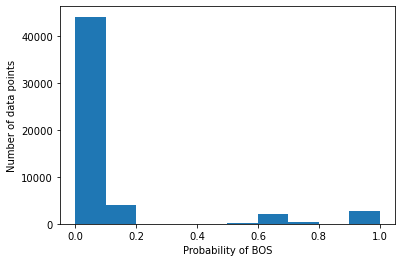

In [38]:
np.around(label_model.get_weights(), 2) 
import matplotlib.pyplot as plt


def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of BOS")
    plt.ylabel("Number of data points")
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, BOS])

In [39]:
np.around(label_model.get_weights(), 2) 

array([0.93, 0.63, 0.75, 1.  , 1.  , 0.72, 0.87, 0.72, 1.  , 0.7 , 0.77,
       1.  ])

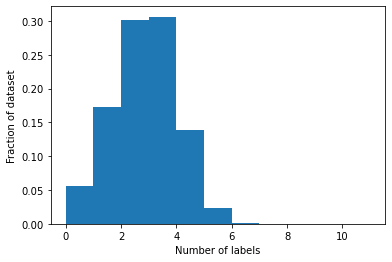

In [40]:
def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

### Etude des erreurs dans la sortie du modèle génératif

In [41]:
# Etude des erreurs après le modèle génératif

probs_dev = label_model.predict_proba(L_dev)

label=[]
for e in probs_dev:
    if e[1]>e[0] and e[1]>0.5:
        label.append(1)
    else:
        label.append(0)

#création fichier 
word2=df_dev["word"].values

df_analysis=pd.DataFrame({"word" : word2, "label": label, "gold" : Y_dev})
df_analysis.head()


df_obs2=df_analysis[(df_analysis["label"]==0) & (df_analysis["gold"]==1)]
a=df_obs2['word'].value_counts()
print(a[:20])


#df_analysis.to_csv("analysis.csv")

euh      33
ouais    23
bon      17
ça       16
c'       16
hum      13
en       12
voilà    11
on       11
que      10
ce       10
je       9 
si       9 
il       8 
d'       7 
ok       7 
est      7 
et       7 
le       7 
pour     6 
Name: word, dtype: int64


## 8. Création de fichiers utiles sur la sortie du modèle génératif

1.Fichier pour entrainement/fine-tuning de ToNy
<br>
2.Fichier de visualisation des BOS de sortie du modèle génératif , comparaison avec le GOLD
<br>
3.Fichier de visualisation des virgules et leur lien avec les BOS
<br>
4.Fichier de visualisation des vrais tours VS tours détectés automatiquement 
<br>

### 1.Fichier pour entrainement/fine-tuning de ToNy

In [159]:
probs_train = label_model.predict_proba(L_train)

label=[]
for e in probs_train:
    if e[1]>e[0] and e[1]>0.5:
        label.append(1)
    else:
        label.append(0)

#création fichier 

file_tony=open("file_train_tony_18022021_V2beground.txt", "w")
i=0

for x in df_train.itertuples():
    if x.rank_round==0:
        file_tony.write("\n")
    if label[i]==1:
        file_tony.write(str(x.word)+"\t"+"NN"+"\t"+"O"+"\t"+"B-S"+"\n")
    else:
        file_tony.write(str(x.word)+"\t"+"NN"+"\t"+"O"+"\t"+"O"+"\n")
    i+=1
file_tony.close()


In [248]:
#création fichier 

file_tony=open("file_gold_dev_tony.txt", "w")
i=0

for x in df_dev.itertuples():
    if x.rank_round==0:
        file_tony.write("\n")
    if Y_dev[i]==1:
        file_tony.write(str(x.word)+"\t"+"NN"+"\t"+"O"+"\t"+"B-S"+"\n")
    else:
        file_tony.write(str(x.word)+"\t"+"NN"+"\t"+"O"+"\t"+"O"+"\n")
    i+=1

file_tony.close()

### 2.Fichier de visualisation des BOS de sortie du modèle génératif , comparaison avec le GOLD

In [ ]:
# création d'un fichier de sortie joli pour vérifier qualitativement si ça marche bien 


label=[]
for e in probs_dev:
    if e[1]>e[0] and e[1]>0.5:
        label.append(1)
    else:
        label.append(0)

#création fichier 

file=open("readable_bos_output_generative_model.txt", "w")


i=0
liste_texte=[]

for x in df_dev.itertuples():
    mot=x.word
    if x.real_rank_round==0 :
        if x.prob_point_bef<0.5 and i>0 and x.prob_comma_bef<0.5:
            liste_texte.append(".")
        liste_texte.append("\n"+"\n"+"---Spk---"+"\n"+"\n")

    if label[i]==1:
        liste_texte.append("|D|")
    if Y_dev[i]==1:
        liste_texte.append("|G|")      
    
    
    if x.prob_point_bef>0.5 or x.real_rank_round==0:
        mot=str(mot).capitalize()
    
    if x.prob_point>0.5:
        mot=mot+"."

    if x.prob_comma>0.5:
        mot=mot+","

    liste_texte.append(mot)
    
    
    

        
    i+=1
    if i==len(df_dev):
        liste_texte.append(".")

file.write(" ".join(liste_texte))

file.close()
    

### 3.Fichier de visualisation des virgules et leur lien avec les BOS

In [ ]:
# visualisation des virgules 

label=[]
for e in probs_dev:
    if e[1]>e[0] and e[1]>0.5:
        label.append(1)
    else:
        label.append(0)

#création fichier 

file=open("virgules_bos_19012021.txt", "w")


i=0
liste_texte=[]

for x in df_dev.itertuples():
    mot=x.word
    if x.real_rank_round==0 :
        if x.prob_point_bef<0.5 and i>0 and x.prob_comma_bef<0.3:
            liste_texte.append(".")
        liste_texte.append("\n"+"\n"+"---Spk---"+"\n"+"\n")

    if Y_dev[i]==1:
        liste_texte.append("|G|")      
    
    
    if x.prob_point_bef>0.5 or x.real_rank_round==0:
        mot=str(mot).capitalize()
    
    if x.prob_point>0.5:
        mot=mot+"."

    if x.prob_comma>0.3:
        mot=mot+","

    liste_texte.append(mot)
    
    
    

        
    i+=1
    if i==len(df_dev):
        liste_texte.append(".")

file.write(" ".join(liste_texte))

file.close()

### 4. Fichier de visualisation des vrais tours VS tours détectés automatiquement 

In [ ]:
# visualisation erreur d echangmenet de speaker 


label=[]
for e in probs_dev:
    if e[1]>e[0] and e[1]>0.5:
        label.append(1)
    else:
        label.append(0)

#création fichier 

file=open("spk_change.txt", "w")


i=0
liste_texte=[]

for x in df_dev.itertuples():
    mot=x.word
    if x.rank_round==0 :
        if x.prob_point_bef<0.5 and i>0 and x.prob_comma_bef<0.5:
            liste_texte.append(".")
        liste_texte.append("\n"+"\n"+"---Spk detected---"+"\n"+"\n")

    if x.real_rank_round==0:
        liste_texte.append("|SPK|")
     
   
    if x.prob_point_bef>0.5 or x.real_rank_round==0:
        mot=str(mot).capitalize()
    
    if x.prob_point>0.5:
        mot=mot+"."

    if x.prob_comma>0.5:
        mot=mot+","

    liste_texte.append(mot)
    
    
    

        
    i+=1
    if i==len(df_dev):
        liste_texte.append(".")

file.write(" ".join(liste_texte))

file.close()

In [39]:
# visualisation erreur d echangmenet de speaker 




file=open("spk_change_comparison_R1.txt", "w")


i=0
liste_texte=[]

for x in df_dev.itertuples():
    mot=x.word
    if x.real_rank_round==0 :
        if x.prob_point_bef<0.5 and i>0 and x.prob_comma_bef<0.5:
            liste_texte.append(".")
        liste_texte.append("\n"+"\n"+"---Real turn---"+"\n"+"\n")
        

    if x.rank_round==0:
        liste_texte.append("|D_SPK|")
    
    #if label[i]==1:
        #liste_texte.append("|D_BOS|")
        
    
    
    if x.prob_point_bef>0.5 or x.real_rank_round==0:
        mot=str(mot).capitalize()
    
    if x.prob_point>0.5:
        mot=mot+"."

    if x.prob_comma>0.5:
        mot=mot+","

    liste_texte.append(mot)
    
    
    

        
    i+=1
    if i==len(df_dev):
        liste_texte.append(".")

file.write(" ".join(liste_texte))
print("bonjou")
file.close()

bonjou


#### Création de fichier pour la démo Gautier

In [45]:
# RAP 4
probs_train = label_model.predict_proba(L_train)
label=[]
for e in probs_train:
    if e[1]>e[0] and e[1]>0.5:
        label.append(1)
    else:
        label.append(0)


df_train_bos=df_train.copy()

print(len(df_train_bos), len(label))    
    
df_train_bos["bos_snorkel"]=label

53692 53692


In [48]:
#df_train_bos.head()

In [64]:
#df_train_bos["bos_snorkel"]=label

df_train_bos.head()

file=open("rap4_actes_dialogues.txt","w")

df_r4=df_train_bos[(df_train_bos["file"]=="Linagora_R4")]

df_r4.head()
i=0
deb=float(df_r4.iat[0,2])
print(deb)
text=[]
for x in df_r4.itertuples():
    if x.bos_snorkel==1 and i!=0:
        
        file.write("\n"+"Linagora_R4 "+str(deb)+" "+str(x.beg_word)+" "+" ".join(text))
        deb=x.beg_word
        text=[]
        
    text.append(x.word)
    i+=1
        
file.close()


37.74


In [ ]:
file=open("real_truns_timestamp")

for x in df_dev.itertuples():
    if x.real_rank_round==0:
        